In [2]:
import psycopg2
import json
from collections import defaultdict
import pandas as pd
import numpy as np

## Setup Database Connection

In [20]:
import psycopg2.extensions
from psycopg2.extras import LoggingConnection, LoggingCursor
import logging

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# MyLoggingCursor simply sets self.timestamp at start of each query                                                                 
class MyLoggingCursor(LoggingCursor):
    def execute(self, query, vars=None):
        self.timestamp = time.time()
        return super(MyLoggingCursor, self).execute(query, vars)

    def callproc(self, procname, vars=None):
        self.timestamp = time.time()
        return super(MyLoggingCursor, self).callproc(procname, vars)

# MyLogging Connection:                                                                                                             
#   a) calls MyLoggingCursor rather than the default                                                                                
#   b) adds resulting execution (+ transport) time via filter()                                                                     
class MyLoggingConnection(LoggingConnection):
    def filter(self, msg, curs):
        return msg.decode(psycopg2.extensions.encodings[self.encoding], 'replace') + "   %d ms" % int((time.time() - curs.timestamp) * 1000)

    def cursor(self, *args, **kwargs):
        kwargs.setdefault('cursor_factory', MyLoggingCursor)
        return LoggingConnection.cursor(self, *args, **kwargs)

In [22]:
db_settings ={"host":"localhost",
                        "port":"5432",
                        "user":"postgres",
                        "password":"11111111",
                        "database":"postgres"}
conn = psycopg2.connect(connection_factory=LoggingConnection, **db_settings)
conn.autocommit = True
conn.initialize(logger)
cursor = conn.cursor()

In [35]:
dapp_df = pd.DataFrame.from_dict(data, orient='index')

In [39]:
dapp_df.loc["PepeDapp","description"]

''

In [45]:
dapp_df.columns

Index(['name', 'chain', 'category', 'balance', 'users', 'volume', 'imageUrl',
       'social', 'description', 'smart_contract', 'url'],
      dtype='object')

In [61]:
subset_df = dapp_df.drop(["social","smart_contract"], axis=1)

In [49]:
subset_df.columns

Index(['name', 'chain', 'category', 'balance', 'users', 'volume', 'imageUrl',
       'description', 'url'],
      dtype='object')

In [62]:
subset_df = subset_df.replace("'", '"', regex=True)

In [63]:
dapp_dict = subset_df.to_dict(orient='tight')

In [64]:
dapp_tuple = [tuple(i) for i in dapp_dict['data']]

In [81]:
sql1 = '''
CREATE TABLE dapps(
    id SERIAL PRIMARY KEY,
    name VARCHAR NOT NULL, 
    chain VARCHAR NOT NULL, 
    category VARCHAR, 
    balance VARCHAR, 
    users VARCHAR, 
    volume VARCHAR, 
    imageUrl VARCHAR, 
    description VARCHAR, 
    url VARCHAR)
'''
cursor.execute(sql1)

In [80]:
sql_drop = "DROP TABLE dapps";
cursor.execute(sql_drop)

In [82]:
for i in dapp_tuple:
    sql2='''insert into dapps(name, chain, category, balance, users, volume, imageUrl, description, url)
            VALUES{};'''.format(i)
    cursor.execute(sql2)

### Import data

In [10]:
with open('../data/vrdb/vr_complete.json','r') as f:
    data = json.load(f)

### Transform data

In [11]:
new_dict = defaultdict(dict)
for k, v in data.items():
    new_dict[k]['title'] = v['title']
    new_dict[k]['description'] = v['desc']
    new_dict[k]['game_modes'] = v['additional_data']['Game Modes'] if 'Game Modes' in v['additional_data'] else ''
    new_dict[k]['supported_player_modes'] = v['additional_data']['Supported Player Modes'] if 'Supported Player Modes' in v['additional_data'] else ''
    new_dict[k]['supported_controllers'] = v['additional_data']['Supported Controllers'] if 'Supported Controllers' in v['additional_data'] else ''
    new_dict[k]['supported_platforms'] = v['additional_data']['Supported Platforms'] if 'Supported Platforms' in v['additional_data'] else ''
    new_dict[k]['category'] = v['additional_data']['Category'] if 'Category' in v['additional_data'] else ''
    new_dict[k]['genres'] = v['additional_data']['Genres'] if 'Genres' in v['additional_data'] else ''
    new_dict[k]['languages'] = v['additional_data']['Languages'] if 'Languages' in v['additional_data'] else ''
    new_dict[k]['version'] = v['additional_data']['Version'] if 'Version' in v['additional_data'] else v['additional_data']['Version + Release Notes']
    new_dict[k]['developer'] = v['additional_data']['Developer'] if 'Developer' in v['additional_data'] else ''
    new_dict[k]['publisher'] = v['additional_data']['Publisher'] if 'Publisher' in v['additional_data'] else ''
    new_dict[k]['website'] = v['additional_data']['Website'] if 'Website' in v['additional_data'] else ''
    new_dict[k]['release_date'] = v['additional_data']['Release Date'] if 'Release Date' in v['additional_data'] else ''
    new_dict[k]['space_required'] = v['additional_data']['Space Required'] if 'Space Required' in v['additional_data'] else ''
    

In [12]:
vr_df = pd.DataFrame.from_dict(new_dict, orient='index')

In [13]:
vr_df = vr_df.replace('\n',' ', regex=True)
vr_df = vr_df.replace("'", '"', regex=True)

In [14]:
db_dict = vr_df.to_dict(orient='tight')

In [15]:
db_tuple = [tuple(i) for i in db_dict['data']]

In [30]:
vr_df.iloc[[3],[1]]

,description
Alien Extraction Demo,"There""s a big alien mess and somebody""s gotta ..."


# SQL Query

### CREATE TABLE vr_applications

In [24]:
import time
from datetime import datetime

In [5]:
sql_drop = "DROP TABLE vr_applications";
cursor.execute(sql_drop)

In [6]:
sql_drop = "DROP TABLE vr_applications_dup";
cursor.execute(sql_drop)

In [7]:
sql1 = '''
CREATE TABLE vr_applications(
    id SERIAL PRIMARY KEY,
    title VARCHAR NOT NULL, 
    description VARCHAR NOT NULL, 
    game_modes VARCHAR, 
    supported_player_modes VARCHAR, 
    supported_controllers VARCHAR, 
    supported_platforms VARCHAR, 
    category VARCHAR, 
    genres VARCHAR, 
    languages VARCHAR, 
    version VARCHAR, 
    developer VARCHAR, 
    publisher VARCHAR, 
    website VARCHAR, 
    release_date VARCHAR, 
    space_required VARCHAR)
'''
cursor.execute(sql1)

In [8]:
sql1 = '''
CREATE TABLE vr_applications_dup(
    id SERIAL PRIMARY KEY,
    title VARCHAR NOT NULL, 
    description VARCHAR NOT NULL, 
    game_modes VARCHAR, 
    supported_player_modes VARCHAR, 
    supported_controllers VARCHAR, 
    supported_platforms VARCHAR, 
    category VARCHAR, 
    genres VARCHAR, 
    languages VARCHAR, 
    version VARCHAR, 
    developer VARCHAR, 
    publisher VARCHAR, 
    website VARCHAR, 
    release_date VARCHAR, 
    space_required VARCHAR)
'''
cursor.execute(sql1)

### INSERT data to vr_applications

In [16]:
for i in db_tuple:
    sql2='''insert into vr_applications(title, description, game_modes, supported_player_modes, supported_controllers, supported_platforms, category, genres, languages, version, developer, publisher, website, release_date, space_required) 
            VALUES{};'''.format(i)
 
    cursor.execute(sql2)

In [17]:
for i in db_tuple:
    sql2='''insert into vr_applications_dup(title, description, game_modes, supported_player_modes, supported_controllers, supported_platforms, category, genres, languages, version, developer, publisher, website, release_date, space_required) 
            VALUES{};'''.format(i)
 
    cursor.execute(sql2)

In [28]:
command = []
command2 = []
# add new column for text search
# command.append("""ALTER TABLE vr_applications ADD COLUMN ts tsvector 
#     GENERATED ALWAYS AS (to_tsvector('english', description)) STORED;""")

# create index
command.append("""CREATE INDEX ts_gin ON vr_applications USING GIN (ts);""")


# add pg_trgm
# command2.append("""CREATE EXTENSION pg_trgm;""")

# create second index
command2.append("""CREATE INDEX ts_trgm ON vr_applications_dup USING GIN (description gin_trgm_ops);""")

for c in command:
    start = datetime.now()
    cursor.execute(c)
    print(f"took {datetime.now() - start} to complete")
    
    
for c in command2:
    start = datetime.now()
    cursor.execute(c)
    print(f"took {datetime.now() - start} to complete")

DEBUG:__main__:b'CREATE INDEX ts_gin ON vr_applications USING GIN (ts);'


took 0:00:01.512358 to complete


DEBUG:__main__:b'CREATE INDEX ts_trgm ON vr_applications_dup USING GIN (description gin_trgm_ops);'


took 0:00:02.788927 to complete


### SELECT a record where it contains "haunted"

In [134]:
sql3 = """SELECT * FROM vr_applications WHERE ts @@ to_tsquery('english', 'haunted');"""

cursor.execute(sql3)

In [135]:
haunted_vr = cursor.fetchall()

In [123]:
# sql_drop = "DROP TABLE vr_applications";
# cursor.execute(sql_drop)

In [138]:
sql1 = '''
CREATE TABLE vr_applications(
    id SERIAL PRIMARY KEY,
    title VARCHAR NOT NULL, 
    description VARCHAR NOT NULL, 
    game_modes VARCHAR, 
    supported_player_modes VARCHAR, 
    supported_controllers VARCHAR, 
    supported_platforms VARCHAR, 
    category VARCHAR, 
    genres VARCHAR, 
    languages VARCHAR, 
    version VARCHAR, 
    developer VARCHAR, 
    publisher VARCHAR, 
    website VARCHAR, 
    release_date VARCHAR, 
    space_required VARCHAR)
'''
cursor.execute(sql1)

### INSERT data to vr_applications

In [ ]:
for i in db_tuple:
    sql2='''insert into vr_applications(title, description, game_modes, supported_player_modes, supported_controllers, supported_platforms, category, genres, languages, version, developer, publisher, website, release_date, space_required) 
            VALUES{};'''.format(i)
 
    cursor.execute(sql200)

In [133]:
command = []
# add new column for text search
command.append("""ALTER TABLE vr_applications ADD COLUMN ts tsvector 
    GENERATED ALWAYS AS (to_tsvector('english', description)) STORED;""")

# create index
command.append("""CREATE INDEX ts_idx ON vr_applications USING GIN (ts);""")

for c in command:
    cursor.execute(c)

### SELECT a record where it contains "haunted"

In [134]:
sql3 = """explain analyze SELECT *
FROM vr_applications
WHERE ts @@ to_tsquery('english', 'haunted');"""

cursor.execute(sql3)

In [135]:
haunted_vr = cursor.fetchall()

In [6]:
# es.search(index="description", q="big alien mess")
sql_q2 = "explain analyze SELECT title FROM vr_applications WHERE ts @@ to_tsquery('english', 'music & game');"

# Testing performance

In [201]:
import re
from collections import defaultdict, OrderedDict

In [185]:
def pg_took(d):
    data = str(d[-2][0])
    data = re.sub("[^:]*:","",data)
    data = re.sub("ms","",data)
    data = float(data.strip())
    
    data2 = str(d[-1][0])
    data2 = re.sub("[^:]*:","",data2)
    data2 = re.sub("ms","",data2)
    data2 = float(data2.strip())
    return data + data2

def es_took(data):
    return data['took']

def exec_pg(query):
    try:
        query = " & ".join(query.split(' '))
        cursor.execute(f"explain analyze SELECT title FROM vr_applications WHERE ts @@ to_tsquery('english', '{query}');")
        data = cursor.fetchall()
    except:
        print(query)
    return data

def exec_es(query):
    data = es.search(index="description", q=query)
    return data

In [191]:
def listify_query(q):
    qlist = q.split(" ")
    return [" ".join(qlist[:n]) for n in range(len(qlist),0,-1)]

In [192]:
sample_query_1 = "MOOD consists of carefully crafted motion arts and sounds united with ancient meditative practices"
queries_1 = listify_query(sample_query_1)

sample_query_2 = "Play the drums like a rock hero, and survive in hell fighting against demons"
queries_2 = listify_query(sample_query_2)

sample_query_3 = "Sledge Destruction Simulator is a physics based VR game that allows you to destroy"
queries_3 = listify_query(sample_query_3)

sample_query_4 = '3D modeling in VR. Use curve-based "patches" to create geometry, and paint them using'
queries_4 = listify_query(sample_query_4)

sample_query_5 = 'Life Simulator VR is a language learning service that trains your "ears" and "vocabulary"'
queries_5 = listify_query(sample_query_5)

q6 = 'Begin your legend now and become a cornhole king. Travel through time to the ruins of an ancient world'
queries_6 = listify_query(q6)

q7 = 'Turn on Sport Mode to take it to the next level of VR physics interaction where your creativity is the limit'
queries_7 = listify_query(q7)

q8 = 'This is an exciting VR aerial combat game. It combines elements of naval warfare.'
queries_8 = listify_query(q8)

q9 = 'Want to make exercise fun? Punch, stretch, squat and step your way to fitness in this 360° game'
queries_9 = listify_query(q9)

q10 = 'PolarDread is a horror game inspired by games in the Sit And Survive Genre that takes the'
queries_10 = listify_query(q10)

In [156]:
es_results = defaultdict(list)
pg_results = defaultdict(list)
queries = [queries_1, queries_2, queries_3, queries_4, queries_5]
for query in queries:
    for q in query:
        es_results[len(q.split(" "))].append(es_took(exec_es(q)))
        pg_results[len(q.split(" "))].append(pg_took(exec_pg(q)))
        

In [181]:
pg_avg = {}
for k, v in pg_results.items():
    pg_avg[k] = sum(v)/len(v)
    
es_avg = {}
for k, v in es_results.items():
    es_avg[k] = sum(v)/len(v)

In [166]:
from matplotlib import pyplot as plt

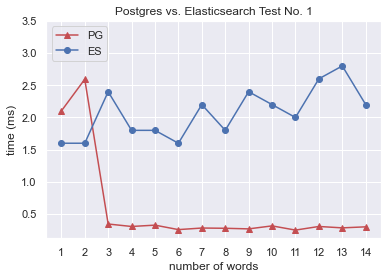

In [243]:
plt.plot(pg_avg.keys(), pg_avg.values(), 'r-^')
plt.plot(es_avg.keys(), es_avg.values(),'b-o')
plt.xticks(np.arange(min(pg_avg.keys()), max(pg_avg.keys())+1, 1.0))
plt.title("Postgres vs. Elasticsearch Test No. 1")
plt.ylabel("time (ms)")
plt.ylim(top=3.5)
plt.xlabel("number of words")
plt.legend(['PG','ES'] , loc='upper left')
plt.show()

In [193]:
es_results2 = defaultdict(list)
pg_results2 = defaultdict(list)
queries = [queries_6, queries_7, queries_8, queries_9, queries_10]
for query in queries:
    for q in query:
        es_results2[len(q.split(" "))].append(es_took(exec_es(q)))
        pg_results2[len(q.split(" "))].append(pg_took(exec_pg(q)))

In [194]:
pg_avg2 = {}
for k, v in pg_results2.items():
    pg_avg2[k] = sum(v)/len(v)
    
es_avg2 = {}
for k, v in es_results2.items():
    es_avg2[k] = sum(v)/len(v)

In [203]:
ordered_pg_avg2 = OrderedDict(sorted(pg_avg2.items()))
ordered_es_avg2 = OrderedDict(sorted(es_avg2.items()))

In [210]:
import seaborn as sns
sns.set()

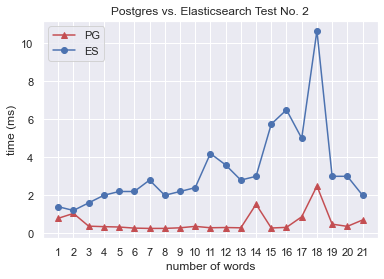

In [242]:

plt.plot(ordered_pg_avg2.keys(), ordered_pg_avg2.values(), 'r-^')
plt.plot(ordered_es_avg2.keys(), ordered_es_avg2.values(),'b-o')

plt.xticks(np.arange(min(pg_avg2.keys()), max(pg_avg2.keys())+1, 1.0))
plt.title("Postgres vs. Elasticsearch Test No. 2")
plt.ylabel("time (ms)")
plt.xlabel("number of words")
plt.legend(['PG','ES'] , loc='upper left')
plt.show()

In [246]:
es_results2

defaultdict(list,
            {19: [4, 2],
             18: [7, 5, 20],
             17: [4, 3, 11, 2],
             16: [2, 2, 17, 5],
             15: [2, 2, 17, 2],
             14: [2, 2, 2, 7, 2],
             13: [2, 2, 3, 5, 2],
             12: [2, 2, 2, 10, 2],
             11: [2, 5, 3, 9, 2],
             10: [2, 2, 1, 5, 2],
             9: [2, 2, 2, 3, 2],
             8: [2, 1, 1, 4, 2],
             7: [5, 2, 2, 3, 2],
             6: [2, 1, 4, 2, 2],
             5: [3, 1, 1, 4, 2],
             4: [1, 3, 2, 2, 2],
             3: [1, 1, 4, 1, 1],
             2: [2, 1, 1, 1, 1],
             1: [1, 3, 1, 1, 1],
             21: [2],
             20: [3]})

In [148]:
set_q1 = set(data_q1)
set_q2 = set(data_q2)

In [151]:
set_q1.difference(set_q2)

{('Big Ballers Basketball',), ('Drums Rock',), ('Jogja Gamelan Virtual',)}

In [152]:
set_q2.difference(set_q1)

{('Air Hockey Arcade',),
 ('Cleansheet',),
 ('Escape Legacy',),
 ('FigureOut VR',),
 ('Pierhead Arcade Quest',),
 ('The Secret of Retropolis Demo',)}

# Elasticsearch

In [3]:
from elasticsearch import Elasticsearch
from datetime import datetime

In [4]:
es = Elasticsearch(
    "https://localhost:9200",
    basic_auth=("elastic", "zMvCcWd2FhYwmDwmLXaG"),
    ca_certs="/Users/jackyangara/http_ca.crt")

In [11]:
descriptions_to_index = list(vr_df.loc[:,"description"])

In [12]:
for idx, desc in enumerate(descriptions_to_index):
    start = datetime.now()
    es.index(index="description3", id=idx, document={"description": desc, "timestamp": datetime.now()})
    print(f"took {datetime.now() - start} to complete")

In [13]:
es.get(index="description", id=1)

ObjectApiResponse({'_index': 'description', '_id': '1', '_version': 1, '_seq_no': 1, '_primary_term': 1, '_ignored': ['description.keyword'], 'found': True, '_source': {'description': 'MOOD consists of carefully crafted motion arts and sounds united with ancient meditative practices to create a uniquely powerful meditative environment. It offers immersive guided meditations for Kindness, Joy, Flow, Cause & Effect, Today, Creativity, Compassion, Relaxation, Self Love, & Change. ', 'timestamp': '2022-03-11T16:05:08.244681'}})

In [106]:
data = es.search(index="description", q="big alien mess")

In [107]:
data['took']

4